In [24]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf

# Prepare training and testing data

In [25]:
with open('../../Datasets/normalized_heart_slimmed.csv') as f:
    temp = np.loadtxt(f, delimiter=',', skiprows=1)

In [26]:
temp.shape

(303, 10)

In [27]:
X = temp[:,:-1]
y = temp[:,-1]
y = np.tensor([-1 if i == 0 else 1 for i in y])

feats_train, feats_test, Y_train, Y_test = train_test_split(X, y,train_size=0.7,random_state=42)


In [28]:
feats_train.shape

(212, 9)

# define varational circuit

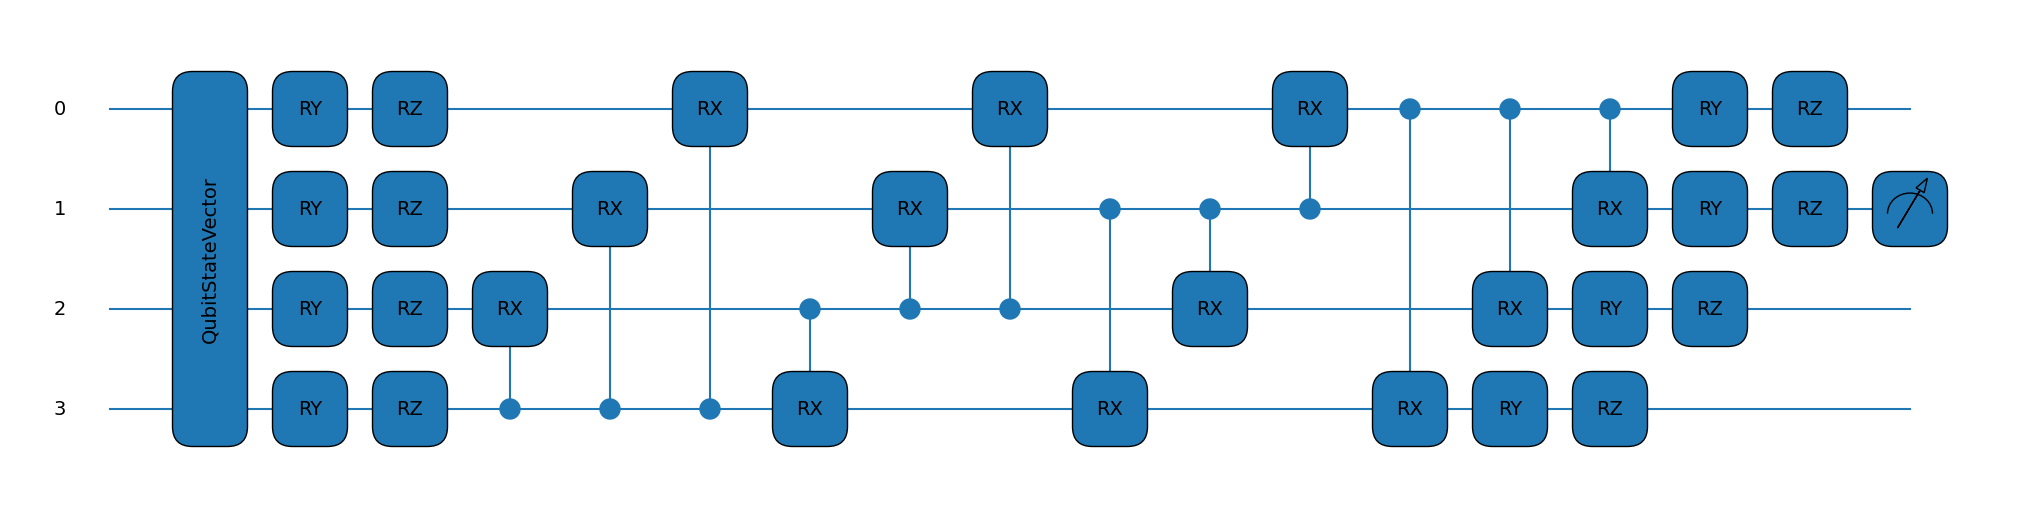

In [32]:
num_wires = 4
dev = qml.device("default.qubit", wires=num_wires)

@qml.qnode(dev, diff_method="backprop")
def circuit(feature_vector,weights=None):
    qml.AmplitudeEmbedding(features=feature_vector, wires=range(num_wires), pad_with=0,normalize=True)
    qml.RY(weights[0], wires=0)
    qml.RZ(weights[1], wires=0)
    qml.RY(weights[2], wires=1)
    qml.RZ(weights[3], wires=1)
    qml.RY(weights[4], wires=2)
    qml.RZ(weights[5], wires=2)
    qml.RY(weights[6], wires=3)
    qml.RZ(weights[7], wires=3)

    qml.CRX(weights[8],wires=[3,2])
    qml.CRX(weights[9],wires=[3,1])
    qml.CRX(weights[10],wires=[3,0])

    qml.CRX(weights[11],wires=[2,3])
    qml.CRX(weights[12],wires=[2,1])
    qml.CRX(weights[13],wires=[2,0])

    qml.CRX(weights[14],wires=[1,3])
    qml.CRX(weights[15],wires=[1,2])
    qml.CRX(weights[16],wires=[1,0])

    qml.CRX(weights[17],wires=[0,3])
    qml.CRX(weights[18],wires=[0,2])
    qml.CRX(weights[19],wires=[0,1])

    # qml.Barrier(only_visual=True,wires=[0,1,2,3])

    qml.RY(weights[20], wires=0)
    qml.RZ(weights[21], wires=0)
    qml.RY(weights[22], wires=1)
    qml.RZ(weights[23], wires=1)
    qml.RY(weights[24], wires=2)
    qml.RZ(weights[25], wires=2)
    qml.RY(weights[26], wires=3)
    qml.RZ(weights[27], wires=3)
    return qml.expval(qml.PauliZ(wires=1))
weights = np.array([0.59, 1.48, 0.02,-1.57, 0.60, 1.49, 0.47, 0.72, -1.15, 3.39, 0.25, 0.19, -0.47, 2.36, 0.36, -0.69, -0.16, 0.51, 0.94, 1.57, 0.29, 0.85, -0.00, 0.34, 0.34, 0.89, 0.85, 0.72], requires_grad=True)
# weights = np.random.random(size=[28], requires_grad=True)
bias = np.array(0.05, requires_grad=True)
# bias = np.array(0.0, requires_grad=True)
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(feats_train[0],weights)

In [31]:
def variational_classifier(weights, bias,feature_vector):
    return circuit( feature_vector,weights)+bias

def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias,f) for f in features]
    loss = 0
    for l, p in zip(labels, predictions):
        loss +=  (l - p) ** 2
    return loss/ len(labels)

def accuracy(labels, predictions):
    success = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 0.5:
            success += 1
    return success/ len(labels)

In [36]:
opt = NesterovMomentumOptimizer(stepsize=0.04)

def mini_batch_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i:min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

num_epochs = 100
batch_size = 20
for epoch in range(num_epochs):
    for feats_train_batch, Y_train_batch in mini_batch_iter(batch_size, feats_train, Y_train):
        feats_train_batch = feats_train_batch.numpy()
        Y_train_batch = Y_train_batch.numpy()
        # Update the weights by one optimizer step
        weights, bias, _, _ = opt.step(cost, weights, bias,feats_train_batch , Y_train_batch)
    
    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_test = [np.sign(variational_classifier(weights, bias, f)) for f in feats_test]
    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_test, predictions_test)
    print(
        "Epoch: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(epoch + 1, cost(weights, bias, X, y), acc_train, acc_val)+str([ float("{:.5f}".format(elem)) for elem in weights.flatten().tolist() ])+str( float("{:.5f}".format(bias)))
    )

Epoch:     1 | Cost: 1.0877604 | Acc train: 0.5283019 | Acc validation: 0.5054945 [0.601, 1.47884, 0.02827, -1.56941, 0.63229, 1.48446, 0.39705, 0.72786, -1.20609, 3.43582, 0.21457, 0.18411, -0.51439, 2.30227, 0.3984, -0.72877, -0.11966, 0.51, 0.94, 1.6751, 0.29, 0.85, 0.03839, 0.34, 0.34, 0.89, 0.85, 0.72]0.26039
Epoch:     2 | Cost: 0.9599167 | Acc train: 0.5424528 | Acc validation: 0.6153846 [0.44968, 1.46798, 0.44016, -1.57346, 0.70954, 1.47693, 0.10239, 0.7325, -1.3398, 3.66649, 0.21721, 0.17414, -0.45157, 2.32954, 0.43902, -0.74396, 0.02653, 0.51, 0.94, 2.04175, 0.29, 0.85, 0.11831, 0.34, 0.34, 0.89, 0.85, 0.72]0.1823
Epoch:     3 | Cost: 0.8928289 | Acc train: 0.6745283 | Acc validation: 0.6703297 [0.18613, 1.4513, 0.62022, -1.62797, 0.82401, 1.46315, -0.19857, 0.73401, -1.58273, 3.90367, 0.33682, 0.16218, -0.32418, 2.39399, 0.4699, -0.74553, 0.22889, 0.51, 0.94, 2.36195, 0.29, 0.85, 0.22471, 0.34, 0.34, 0.89, 0.85, 0.72]0.2884
Epoch:     4 | Cost: 0.8623670 | Acc train: 0.68867

KeyboardInterrupt: 

# I manually termniated training since the accuracy isn't improving.
# it took 6 minute to run 57 epochs.

In [37]:
opt = NesterovMomentumOptimizer(stepsize=0.02)
weights = np.array([0.05929, 1.3814, 0.15166, -2.29727, 0.55235, 1.39186, -1.21211, -0.01631, -2.17202, 3.09755, 1.08503, 0.09238, 0.02815, 1.93709, 1.97272, -1.72479, 0.19734, 0.51, 0.94, 3.35585, 0.29, 0.85, 0.41901, 0.34, 0.34, 0.89, 0.85, 0.72], requires_grad=True)
bias = np.array(0.18558, requires_grad=True)

def mini_batch_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i:min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

num_epochs = 2
batch_size = 50
for epoch in range(num_epochs):
    for feats_train_batch, Y_train_batch in mini_batch_iter(batch_size, feats_train, Y_train):
        feats_train_batch = feats_train_batch.numpy()
        Y_train_batch = Y_train_batch.numpy()
        # Update the weights by one optimizer step
        weights, bias, _, _ = opt.step(cost, weights, bias,feats_train_batch , Y_train_batch)
    
    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_test = [np.sign(variational_classifier(weights, bias, f)) for f in feats_test]
    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_test, predictions_test)
    print(
        "Epoch: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(epoch + 1, cost(weights, bias, X, y), acc_train, acc_val)+str([ float("{:.5f}".format(elem)) for elem in weights.flatten().tolist() ])+str( float("{:.5f}".format(bias)))
    )

Epoch:     1 | Cost: 0.7558998 | Acc train: 0.7311321 | Acc validation: 0.7032967 [0.05908, 1.38183, 0.15186, -2.2983, 0.55135, 1.39122, -1.20981, -0.01643, -2.16995, 3.09535, 1.08698, 0.09195, 0.02526, 1.93896, 1.97308, -1.72742, 0.1897, 0.51, 0.94, 3.35393, 0.29, 0.85, 0.41466, 0.34, 0.34, 0.89, 0.85, 0.72]0.13943
Epoch:     2 | Cost: 0.7560312 | Acc train: 0.7500000 | Acc validation: 0.6813187 [0.05997, 1.38241, 0.14849, -2.30135, 0.54191, 1.39257, -1.20336, -0.01554, -2.17361, 3.09433, 1.08644, 0.0896, 0.02171, 1.95203, 1.97325, -1.72708, 0.18353, 0.51, 0.94, 3.35073, 0.29, 0.85, 0.40573, 0.34, 0.34, 0.89, 0.85, 0.72]0.0799


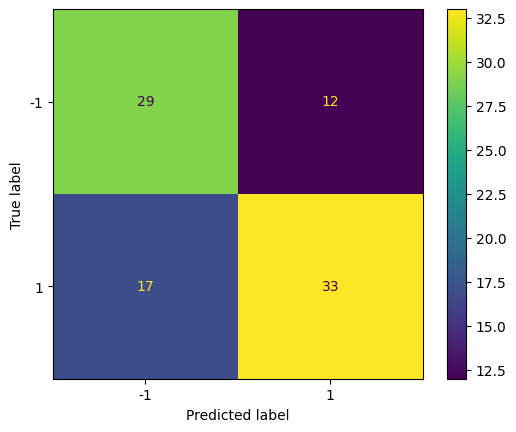

In [38]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import matplotlib.pyplot as plt

predictions_test = [np.sign(variational_classifier(weights, bias, f)) for f in feats_test]

cm = confusion_matrix(Y_test, predictions_test, labels=[-1,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[-1,1])
disp.plot()
plt.show()